## Imports

In [2]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import download
from random import shuffle
from keras.applications import VGG16
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Activation
import sys
import h5py

In [69]:
import numpy
numpy.set_printoptions(threshold=np.inf)

In [6]:
keras.__version__

'2.4.3'

In [7]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [8]:
def download_data(in_dir, url):
    
    if not os.path.exists(in_dir):
        os.makedirs(in_dir)
    
    download.maybe_download_and_extract(url,in_dir)

In [9]:
in_dir = "data"

In [11]:
url_hockey = "http://visilab.etsii.uclm.es/personas/oscar/FightDetection/HockeyFights.zip"

In [12]:
download_data(in_dir,url_hockey)

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [13]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

In [14]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

In [15]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

In [16]:
# First get the names and labels of the whole videos
names, labels = label_video_names(in_dir)

In [17]:
names[12]

'no206_xvid.avi'

In [18]:
frames = get_frames(in_dir, names[12])

In [19]:
visible_frame = (frames*255).astype('uint8')

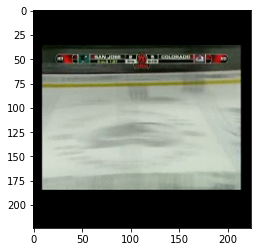

In [20]:
plt.imshow(visible_frame[3])

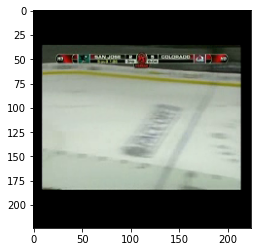

In [21]:
plt.imshow(visible_frame[15])

The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for classification. If include_top=True then the whole VGG16 model is downloaded which is about 528 MB. If include_top=False then only the convolutional part of the VGG16 model is downloaded which is just 57 MB.

In [22]:
image_model = VGG16(include_top=True, weights='imagenet')

553467904/553467096 [==============================] - 93s 0us/step


In [23]:
image_model.summary()



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We can observe the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3. Note that we have defined the frame size as 224x224x3. The video frame will be the input of the VGG16 net.

In [25]:
input_shape = image_model.layers[0].output_shape[1:3]
input_shape

[]

The following chart shows how the data flows when using the VGG16 model for Transfer Learning. First we input and process 20 video frames in batch with the VGG16 model. Just prior to the final classification layer of the VGG16 model, we save the so-called Transfer Values to a cache-file.

The reason for using a cache-file is that it takes a long time to process an image with the VGG16 model. If each image is processed more than once then we can save a lot of time by caching the transfer-values.

When all the videos have been processed through the VGG16 model and the resulting transfer-values saved to a cache file, then we can use those transfer-values as the input to LSTM neural network. We will then train the second neural network using the classes from the violence dataset (Violence, No-Violence), so the network learns how to classify images based on the transfer-values from the VGG16 model.

In [26]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


In [27]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

In [28]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

We are going to define functions to get the transfer values from VGG16 with defined number of files. Then save the transfer values files used from training in one file and the ones uses for testing in another one. 

In [29]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [30]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

We are going to split the dataset into training set and testing. The training set is used to train the model and the test set to check the model accuracy.

In [31]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

Then we are going to process all video frames through VGG16 and save the transfer values.

In [32]:
make_files(training_set)

- Progress: 99.9%

In [33]:
make_files_test(test_set)

- Progress: 99.5%

### Load the cached transfer values into memory

In order to load the saved transfer values into RAM memory we are going to use this two functions:

In [34]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [35]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [36]:
data, target = process_alldata_training()

In [37]:
data_test, target_test = process_alldata_test()

The first input dimension of LSTM neurons is the temporal dimension, in our case it is 20. The second is the size of the features vector (transfer values).


In [38]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               9439232   
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                51250     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0

## Model training


In [39]:
epoch = 200
batchS = 500
history = model.fit(np.array(data[0:750]), np.array(target[0:750]), epochs=epoch,
                    validation_data=(np.array(data[750:]), np.array(target[750:])), 
                    batch_size=batchS, verbose=2)

Epoch 1/200
2/2 - 2s - loss: 0.3291 - accuracy: 0.5067 - val_loss: 0.2966 - val_accuracy: 0.4600
Epoch 2/200
2/2 - 2s - loss: 0.2694 - accuracy: 0.5200 - val_loss: 0.2663 - val_accuracy: 0.5400
Epoch 3/200
2/2 - 2s - loss: 0.2710 - accuracy: 0.5093 - val_loss: 0.2481 - val_accuracy: 0.5400
Epoch 4/200
2/2 - 2s - loss: 0.2488 - accuracy: 0.5120 - val_loss: 0.2608 - val_accuracy: 0.4600
Epoch 5/200
2/2 - 2s - loss: 0.2545 - accuracy: 0.4907 - val_loss: 0.2495 - val_accuracy: 0.4600
Epoch 6/200
2/2 - 2s - loss: 0.2468 - accuracy: 0.5067 - val_loss: 0.2454 - val_accuracy: 0.5400
Epoch 7/200
2/2 - 2s - loss: 0.2480 - accuracy: 0.5093 - val_loss: 0.2429 - val_accuracy: 0.5400
Epoch 8/200
2/2 - 2s - loss: 0.2433 - accuracy: 0.5093 - val_loss: 0.2417 - val_accuracy: 0.7800
Epoch 9/200
2/2 - 2s - loss: 0.2406 - accuracy: 0.7187 - val_loss: 0.2381 - val_accuracy: 0.7800
Epoch 10/200
2/2 - 2s - loss: 0.2335 - accuracy: 0.7573 - val_loss: 0.2292 - val_accuracy: 0.5400
Epoch 11/200
2/2 - 2s - loss:

Epoch 85/200
2/2 - 2s - loss: 0.0494 - accuracy: 0.9440 - val_loss: 0.0866 - val_accuracy: 0.9200
Epoch 86/200
2/2 - 2s - loss: 0.0495 - accuracy: 0.9440 - val_loss: 0.0882 - val_accuracy: 0.9200
Epoch 87/200
2/2 - 2s - loss: 0.0494 - accuracy: 0.9427 - val_loss: 0.0873 - val_accuracy: 0.9200
Epoch 88/200
2/2 - 2s - loss: 0.0500 - accuracy: 0.9413 - val_loss: 0.0863 - val_accuracy: 0.9200
Epoch 89/200
2/2 - 2s - loss: 0.0512 - accuracy: 0.9440 - val_loss: 0.0907 - val_accuracy: 0.9000
Epoch 90/200
2/2 - 2s - loss: 0.0485 - accuracy: 0.9440 - val_loss: 0.0951 - val_accuracy: 0.8800
Epoch 91/200
2/2 - 2s - loss: 0.0501 - accuracy: 0.9440 - val_loss: 0.0869 - val_accuracy: 0.9200
Epoch 92/200
2/2 - 2s - loss: 0.0463 - accuracy: 0.9520 - val_loss: 0.0937 - val_accuracy: 0.8800
Epoch 93/200
2/2 - 2s - loss: 0.0465 - accuracy: 0.9507 - val_loss: 0.0883 - val_accuracy: 0.9200
Epoch 94/200
2/2 - 2s - loss: 0.0479 - accuracy: 0.9480 - val_loss: 0.0958 - val_accuracy: 0.8800
Epoch 95/200
2/2 - 2

Epoch 168/200
2/2 - 2s - loss: 0.0370 - accuracy: 0.9613 - val_loss: 0.1141 - val_accuracy: 0.8600
Epoch 169/200
2/2 - 2s - loss: 0.0410 - accuracy: 0.9560 - val_loss: 0.1038 - val_accuracy: 0.8800
Epoch 170/200
2/2 - 2s - loss: 0.0404 - accuracy: 0.9560 - val_loss: 0.1049 - val_accuracy: 0.8800
Epoch 171/200
2/2 - 2s - loss: 0.0373 - accuracy: 0.9587 - val_loss: 0.0962 - val_accuracy: 0.8800
Epoch 172/200
2/2 - 2s - loss: 0.0368 - accuracy: 0.9627 - val_loss: 0.1079 - val_accuracy: 0.8800
Epoch 173/200
2/2 - 2s - loss: 0.0383 - accuracy: 0.9600 - val_loss: 0.0929 - val_accuracy: 0.8800
Epoch 174/200
2/2 - 2s - loss: 0.0367 - accuracy: 0.9627 - val_loss: 0.1274 - val_accuracy: 0.8400
Epoch 175/200
2/2 - 2s - loss: 0.0487 - accuracy: 0.9360 - val_loss: 0.1088 - val_accuracy: 0.8800
Epoch 176/200
2/2 - 2s - loss: 0.0438 - accuracy: 0.9493 - val_loss: 0.1037 - val_accuracy: 0.8800
Epoch 177/200
2/2 - 2s - loss: 0.0369 - accuracy: 0.9587 - val_loss: 0.0909 - val_accuracy: 0.9000
Epoch 178/

## Test the model

In [40]:
result = model.evaluate(np.array(data_test), np.array(target_test))

7/7 [==============================] - 1s 190ms/step - loss: 0.0491 - accuracy: 0.9450


In [41]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.04911315068602562
accuracy 0.9449999928474426


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


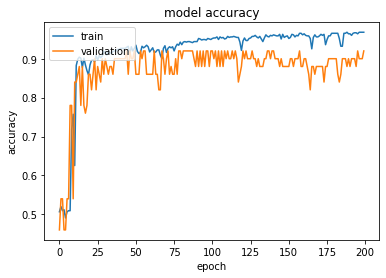

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


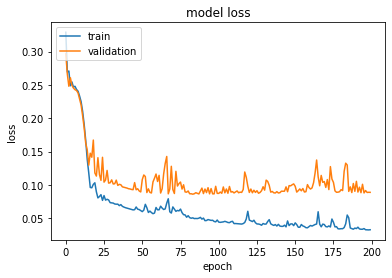

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

In [124]:
def infer(curr_dir,file_name):
    tr = get_transfer_values(curr_dir,file_name)
    tr = tr[np.newaxis,...]
    pred = model.predict(np.array(tr))
    print(pred[0])
    res = np.argmax(pred)
    if res == 0:
        print("Violent Video with confidence: "+str(round(pred[0][res]*100,2))+" %")
    else:
        print("Non-Violent Video with confidence: "+str(round(pred[0][res]*100,2))+" %")

In [131]:
infer(in_dir,"no12_xvid.avi")

[0.01168198 0.988318  ]
Non-Violent Video with confidence: 98.83 %


In [114]:
!mkdir model

In [115]:
model.save('model/vlstm_92')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/vlstm_92\assets


In [116]:
model.save('model/vlstm_92.h5')